$\text{}$

$$\LARGE\text{Assignment: Dimensionality Reduction}$$

$$\large\text{Qianlang Chen (u1172983)}$$

$$\text{CS 5140 Spring 2021}$$

$\text{}$

In [2]:
import numpy

A = numpy.loadtxt('./data/A.csv', delimiter=',')
print(A.shape)

(3500, 20)


# Problem 1

## Part A

In [3]:
from scipy import linalg

U, S, Vt = linalg.svd(A)
S = numpy.identity(len(S)) * S

def Ak(k):
    Uk = U[:,:k]
    Sk = S[:k,:k]
    Vtk = Vt[:k,:]
    return Uk @ Sk @ Vtk

K = tuple(range(1, 11))
for k in K:
    print(f'k = {k}: {linalg.norm(A - Ak(k), 2)}')

k = 1: 100.00246446709691
k = 2: 92.11139537014573
k = 3: 87.43842799887248
k = 4: 70.84270143876726
k = 5: 58.89263665883072
k = 6: 57.77458152758134
k = 7: 25.86135552441823
k = 8: 24.871609868369216
k = 9: 24.395000417106157
k = 10: 22.997273663616927


## Part B

In [4]:
norm_A = linalg.norm(A, 2)

K = tuple(range(1, 21))
for k in K:
    if linalg.norm(A - Ak(k), 2) < .2 * norm_A:
        print(k)
        break

10


## Part C

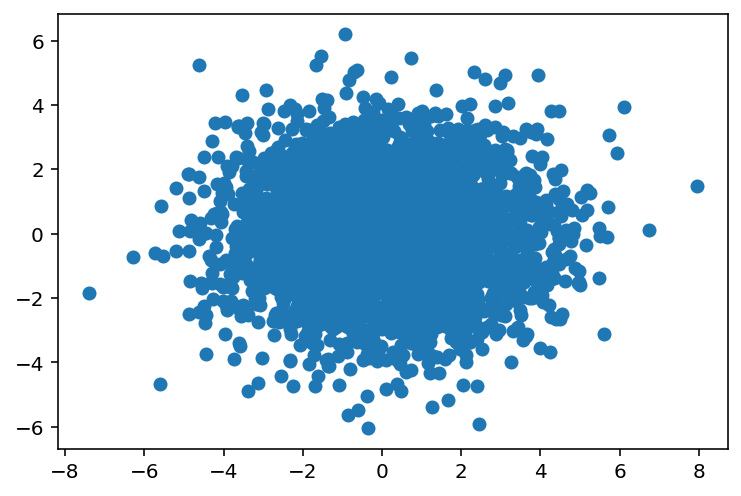

In [10]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot
from sklearn import decomposition

A2 = decomposition.PCA(2).fit_transform(A)
_ = pyplot.scatter(A2[:, 0], A2[:, 1])

I applied the PCA method from the lecture that found a subspace $B$ minimizing $\textsf{SSE}(A, B)$. The algorithm first centered the data points and then performed SVD. I made use of an existing implementation for this method from SciKit-Learn (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

$\pagebreak$

# Problem 2

## Part A

* How large does $l$ need to be for the above error to be at most $||A||_F^2 / 20$?

In [6]:
from lib import FD

def find_min_l(A, err_bound):
    n, d = A.shape
    for l in range(1, n // 2):
        B = FD.freq_dir(A, l)
        err = linalg.norm(A.T @ A - B.T @ B)
        if err <= err_bound:
            return l, err

l, err = find_min_l(A, linalg.norm(A)**2 / 20)
print(l)

7


* How does this compare to the theoretical bound (e.g. for $k = 0$)?

In [7]:
print(f'||Ax||^2 - ||Bx||^2:\t\t\t\t{err}')
for k in range(l):
    print(f'||A - Ak||_F^2 / (l - k) [with l = {l}, k = {k}]:'
          f'\t{linalg.norm(A - Ak(k))**2 / (l - k)}')

||Ax||^2 - ||Bx||^2:				2467.226247591852
||A - Ak||_F^2 / (l - k) [with l = 7, k = 0]:	8075.627550160504
||A - Ak||_F^2 / (l - k) [with l = 7, k = 1]:	7175.904154353963
||A - Ak||_F^2 / (l - k) [with l = 7, k = 2]:	6610.98640532616
||A - Ak||_F^2 / (l - k) [with l = 7, k = 3]:	6142.605717398873
||A - Ak||_F^2 / (l - k) [with l = 7, k = 4]:	5641.648059560493
||A - Ak||_F^2 / (l - k) [with l = 7, k = 5]:	5953.127915769583
||A - Ak||_F^2 / (l - k) [with l = 7, k = 6]:	8437.913178910114


The tightest bound occurred when $k = 4$ (5642), but the bounding expression

$$||Ax||^2 - ||Bx||^2 \le ||A - A_k||_F^2 / (l - k)$$

still holds true.

* How large does $l$ need to be for the above error to be at most $||A - A_k||_F^2 / 20$ (for $k = 2$)?

In [8]:
k = 2
l, err = find_min_l(A, linalg.norm(A - Ak(k))**2 / 20)
print(l)

9


$\pagebreak$

# Appendix

### `lib/FD.py`

In [9]:
import numpy
from scipy import linalg

def freq_dir(A, l):
    n, d = A.shape
    B = numpy.zeros((2 * l, d))
    zero_index = 0
    for i in range(n):
        B[zero_index] = A[i]
        zero_index += 1
        if zero_index == 2 * l: # full
            U, S, Vt = linalg.svd(B)
            delta = S[-1]**2
            S_prime = numpy.zeros((2 * l, d))
            numpy.fill_diagonal(S_prime,
                                [(sigma**2 - delta)**.5 for sigma in S])
            B = S_prime @ Vt
            for zero_index in range(2 * l):
                if not B[zero_index].any(): break # the first empty row
    return B